## QuasarNET Performance vs nchunks
#### Plot to show performance of QuasarNET as a function of the number of boxes/chunks
xxx

In [23]:
import astropy
import copy
import glob
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from quasarnet.io import read_truth
from qn_analysis import plot, strategy, utils, variables

In [24]:
figsize = (12,6.5)
fontsize = 18

temp_output_loc = '/global/cfs/projectdirs/desi/users/jfarr/QuasarNET_paper/'

plt.rc('font', size=fontsize)

### Load the results from the different QN models

In [25]:
## QN parameters
n_detect = 1
c_th = 0.8
include_c_qn = True
common_specids = True

In [26]:
f_truth = variables.OUTDIR+'/data/truth/truth_dr12q.fits'
truth = read_truth([f_truth])

In [27]:
data = {}

for nchunks in variables.NCHUNK_VALUES:

    ## Load the QN using nchunks value.
    f_qn = glob.glob(variables.OUTDIR+'/outputs/qn_outputs/additional_setups/nchunks/nchunks_{}/qnAll*.fits'.format(nchunks))[0]

    data['QN_{}'.format(nchunks)] = utils.load_qn_data(f_qn,n_detect=n_detect,c_th=c_th,include_c=include_c_qn)

### Find the set of common spectra, and reduce all data to that set
This finds which spectra* are common to all datasets, and removes any that are not common. It then matches the data from each classifier to each spectrum, and produces a single data table.

\* using spec_id = plate$\times$1000000000 + mjd$\times$10000 + fiber for BOSS, or spec_id = targetid for DESI (to be updated)

In [28]:
data_table = utils.reduce_data_to_table(data,truth,include_c_qn=include_c_qn,common_specids=False)
data_table[:5]

SPEC_ID,OBJ_ID,ZCONF_PERSON,Z_VI,CLASS_VI,ISQSO_VI,Z_QN_7,CLASS_QN_7,ISQSO_QN_7,C_QN_7 [6],Z_QN_10,CLASS_QN_10,ISQSO_QN_10,C_QN_10 [6],Z_QN_13,CLASS_QN_13,ISQSO_QN_13,C_QN_13 [6],Z_QN_16,CLASS_QN_16,ISQSO_QN_16,C_QN_16 [6],Z_QN_19,CLASS_QN_19,ISQSO_QN_19,C_QN_19 [6]
int64,int64,int64,float64,str8,bool,float64,str8,bool,float64,float64,str8,bool,float64,float64,str8,bool,float64,float64,str8,bool,float64,float64,str8,bool,float64
7166566020362,20589337,2,1.616,QSO,True,1.634,NONQSO,False,0.000 .. 0.003,2.228,NONQSO,False,0.860 .. 0.000,1.617,NONQSO,False,0.393 .. 0.000,1.628,NONQSO,False,0.003 .. 0.000,1.632,NONQSO,False,0.000 .. 0.000
7166566020367,20603085,2,2.070,QSO,True,2.009,QSO,True,0.338 .. 0.000,2.053,QSO,True,0.969 .. 0.000,2.081,QSO,True,1.000 .. 0.000,2.067,NONQSO,False,0.846 .. 0.000,2.046,NONQSO,False,0.927 .. 0.000
7169566280047,20935261,2,0.000,STAR,False,1.472,NONQSO,False,0.000 .. 0.000,0.805,NONQSO,False,0.000 .. 0.000,2.395,NONQSO,False,0.000 .. 0.000,2.988,NONQSO,False,0.000 .. 0.000,2.386,NONQSO,False,0.000 .. 0.000
7169566280046,20935742,2,0.000,STAR,False,0.418,NONQSO,False,0.000 .. 0.000,0.602,NONQSO,False,0.000 .. 0.000,3.548,NONQSO,False,0.000 .. 0.000,2.279,NONQSO,False,0.000 .. 0.000,1.432,NONQSO,False,0.000 .. 0.000
7169566280052,20936956,2,0.000,STAR,False,3.295,NONQSO,False,0.000 .. 0.000,0.139,NONQSO,False,0.000 .. 0.000,2.926,NONQSO,False,0.000 .. 0.000,1.076,NONQSO,False,0.000 .. 0.000,0.722,NONQSO,False,0.000 .. 0.000


In [29]:
# Include only objects in the data table that have the highest confidence level, and VI redshift not equal to -1.
w = (data_table['ZCONF_PERSON']==2) & (data_table['Z_VI']>-1)
data_table = data_table[w]
len(data_table)

506016

### Compare the performance of the different model/data combos.
xxx

In [30]:
ls = {'QN_13': '-',
      'QN_19': '--',
      'QN_16': '-.',
      'QN_10': ':',
      'QN_7': (0, (3, 5, 1, 5, 1, 5)),
     }

In [31]:
## Define general parameter values.
dv_max = 6000.

# confidence thresholds.
c_th_min = 0.0
c_th_max = 1.0
n_int = 100
c_th_values = np.linspace(c_th_min,c_th_max,n_int)

In [32]:
## Define strategies.
strategies = {}

for s in data.keys():
    
    nchunks = int(s.split('_')[-1])
    name = r'$n_{{boxes}}={}$'.format(nchunks)
    if type(data_table['ISQSO_{}'.format(s)])==astropy.table.column.MaskedColumn:
        filt = (~data_table['ISQSO_{}'.format(s)].data.mask)
    else:
        filt = np.ones(len(data_table)).astype(bool)
    
    # QN definitions.
    n_detect = 1
    strat = strategy.Strategy('qn',cf_kwargs={'qn_name':s})
    preds = [strat.predict(data_table,filter=filt,c_kwargs={'c_th':c_th_value,'n_detect':n_detect}) for c_th_value in c_th_values]
    strategies[s] = {'isqso': [pred.isqso for pred in preds],
                     'z': [pred.z for pred in preds],
                     'c_th': c_th_values,
                     'n': name, 
                     'ls': ls[s]}

/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/astropy/table/column.py:991: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(), op)(other)
/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/qn_analysis/plot.py:34: RuntimeWarning: invalid value encountered in long_scalars
  pur = pur_num/pur_denom
/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/qn_analysis/plot.py:266: RuntimeWarning: invalid value encountered in greater
  ind = np.where(pur>com)[0][0]


Strategy QN_7:
Crossover occurs at:
cth: [0.0505 0.0606 0.0707 0.0808]
pur: [0.9915 0.9918 0.992  0.9922]
com: [0.992  0.9919 0.9918 0.9917]
QN_7 has median velocity error -37.385 and standard deviation 954.811

Strategy QN_10:
Crossover occurs at:
cth: [0.1414 0.1515 0.1616 0.1717]
pur: [0.9927 0.9928 0.9929 0.993 ]
com: [0.993  0.993  0.9929 0.9929]
QN_10 has median velocity error -106.142 and standard deviation 868.021

Strategy QN_13:
Crossover occurs at:
cth: [0.0505 0.0606 0.0707 0.0808]
pur: [0.9936 0.9938 0.994  0.9941]
com: [0.9939 0.9939 0.9938 0.9937]
QN_13 has median velocity error -97.058 and standard deviation 770.342

Strategy QN_16:
Crossover occurs at:
cth: [0.0808 0.0909 0.101  0.1111]
pur: [0.9938 0.994  0.9941 0.9942]
com: [0.9942 0.9941 0.994  0.9939]
QN_16 has median velocity error -126.320 and standard deviation 754.495

Strategy QN_19:
Crossover occurs at:
cth: [0.0505 0.0606 0.0707 0.0808]
pur: [0.9939 0.9941 0.9942 0.9944]
com: [0.9944 0.9943 0.9942 0.9941]
QN

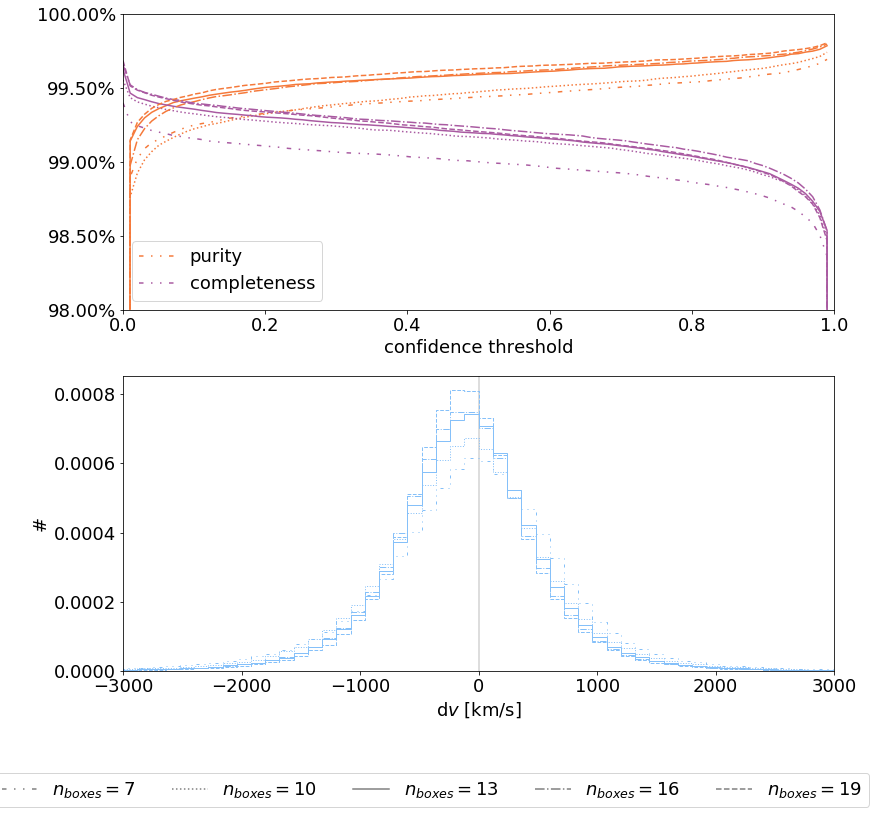

In [33]:
filename = '../plots/qn_performance_vs_nboxes.pdf'

plot.plot_qn_model_compare(data_table,strategies,filename=filename,
                           dv_max=dv_max,nydec=2,figsize=(12,12),
                           ymin=0.98,ymax=1.,verbose=True,npanel=2,
                           norm_dvhist=True)
plt.show()